In [1]:
import skbio
import sklearn
import tslearn
import math
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

### Number of origin region occurrences altogether

In [9]:
# Read data
data = pd.read_csv('/Users/maijahavusela/Desktop/gradu/data/10.4. saadut/Erasmus_2014-2022_aggregated_NUTS3_v2021.csv',sep=',')

# Splitting the origin and destination NUTS 3 codes to separate columns
data['orig'] = data['OD_ID'].apply(lambda x: x.split('_')[0])
data['dest'] = data['OD_ID'].apply(lambda x: x.split('_')[1])

# Getting a list of all origins per destination and renaming the column
opd = data.groupby(['dest', 'year']).agg({'orig':lambda x: list(x)}).reset_index().rename(columns={'dest':'NUTS3'})

# Flattening the 'orig' column and counting occurrences of each NUTS 3 region as an origin
flat_list = [item for sublist in opd['orig'] for item in sublist]
counter = Counter(flat_list)
counter # All years


Counter({'ES300': 4344,
         'TR100': 3779,
         'ES511': 3486,
         'FR101': 3430,
         'HU110': 3402,
         'ES523': 3209,
         'CZ010': 3150,
         'FRE11': 3146,
         'PL911': 3066,
         'PT170': 2986,
         'FRK26': 2974,
         'ITC4C': 2951,
         'AT130': 2927,
         'CZ071': 2777,
         'ITI43': 2762,
         'LT011': 2747,
         'ES614': 2733,
         'ES213': 2688,
         'ES618': 2652,
         'TR510': 2628,
         'ITH55': 2612,
         'BE100': 2530,
         'EL303': 2515,
         'PL213': 2476,
         'PL415': 2427,
         'SI041': 2364,
         'FRI12': 2363,
         'PL514': 2337,
         'LV006': 2337,
         'DE300': 2323,
         'FRJ23': 2298,
         'ITH36': 2292,
         'ITC11': 2287,
         'PT11A': 2286,
         'SK010': 2239,
         'EL522': 2137,
         'FI1B1': 2133,
         'AT221': 2081,
         'LT022': 2056,
         'FRH03': 2049,
         'RO321': 2032,
         'ES243'

### Number of origin region occurrences per destination NUTS 3

In [12]:
# Dictionary to store the Counter results for each destination NUTS 3 region
origin_count_per_dest_nuts3 = {}

# Iterating over each unique destination NUTS 3 region
for nuts3 in opd['NUTS3'].unique():
    # Getting all regions in the 'orig' column for this NUTS 3 region
    regions = [region for sublist in opd[opd['NUTS3'] == nuts3]['orig'] for region in sublist]
    # Counting occurrences of each origin NUTS 3 region using Counter
    origin_count_per_dest_nuts3[nuts3] = Counter(regions)
    
origin_count_per_dest_nuts3 # All years

{'AL012': Counter({'CZ080': 1,
          'TR412': 1,
          'ES114': 1,
          'FRJ13': 1,
          'ITC33': 1,
          'ITC4C': 1,
          'ITF13': 1,
          'ITF35': 1,
          'ITF47': 1,
          'ITG14': 1,
          'ITH52': 1,
          'ITH55': 1}),
 'AL013': Counter({'PL22B': 2, 'HU110': 1, 'FRF33': 1, 'FRK13': 1}),
 'AL015': Counter({'ES611': 1, 'CZ010': 1}),
 'AL021': Counter({'BG411': 4,
          'BG321': 2,
          'ES114': 2,
          'BG413': 2,
          'DE405': 2,
          'ES112': 1,
          'ES521': 1,
          'ES523': 1,
          'ITI32': 1,
          'TRA21': 1}),
 'AL022': Counter({'ES114': 5,
          'ITF47': 4,
          'ITH55': 4,
          'ITI43': 4,
          'DE405': 4,
          'ES300': 4,
          'ITI32': 4,
          'ES611': 4,
          'TR510': 4,
          'FRE11': 3,
          'HU110': 3,
          'IE061': 3,
          'CZ010': 3,
          'DEC01': 3,
          'ITF35': 3,
          'TR322': 3,
          'FRJ13': 

### The Shannon-Weiner diversity index (not normalized)
Shannon equitability index?? Se on normalisoitu 0 ja 1 välille

In [4]:
# Defining a function to calculate the Shannon-Weiner index using skbio
def calculate_shannon_weiner_with_skbio(region_counter):
    counts = list(region_counter.values())  # Converting counter to a list of counts
    shannon_index = skbio.diversity.alpha.shannon(counts)
    return shannon_index

# Calculating Shannon-Weiner index for each destination NUTS 3 region
diversity_indexes = {}
for nuts3, counter in origin_count_per_dest_nuts3.items():
    shannon_index = calculate_shannon_weiner_with_skbio(counter)
    diversity_indexes[nuts3] = shannon_index

# Output the results
for nuts3, index in diversity_indexes.items():
    print(f"Shannon-Weiner index for {nuts3}: {index:.4f}")
    
# 0 on ei yhtään diversiteettiä, mitä korkeempi arvo sitä korkeempi diversiteetti

Shannon-Weiner index for AL012: 2.4849
Shannon-Weiner index for AL013: 1.3322
Shannon-Weiner index for AL015: 0.6931
Shannon-Weiner index for AL021: 2.1808
Shannon-Weiner index for AL022: 4.4045
Shannon-Weiner index for AL031: 1.0986
Shannon-Weiner index for AL032: 1.2425
Shannon-Weiner index for AL033: 0.6931
Shannon-Weiner index for AL034: 1.1537
Shannon-Weiner index for AL035: 2.0198
Shannon-Weiner index for AT111: 2.0947
Shannon-Weiner index for AT112: 4.1831
Shannon-Weiner index for AT113: 2.5475
Shannon-Weiner index for AT121: 3.3475
Shannon-Weiner index for AT122: 4.2480
Shannon-Weiner index for AT123: 4.4374
Shannon-Weiner index for AT124: 4.4635
Shannon-Weiner index for AT125: 3.0749
Shannon-Weiner index for AT126: 4.5088
Shannon-Weiner index for AT127: 4.4833
Shannon-Weiner index for AT130: 6.2343
Shannon-Weiner index for AT211: 5.2546
Shannon-Weiner index for AT212: 4.1735
Shannon-Weiner index for AT213: 3.2452
Shannon-Weiner index for AT221: 5.9099
Shannon-Weiner index for 

### Clustering

/var/folders/y_/10361q_17p1glmj2v2x0zsth0000gn/T/ipykernel_52451/1977722820.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Oranges', len(unique_clusters))


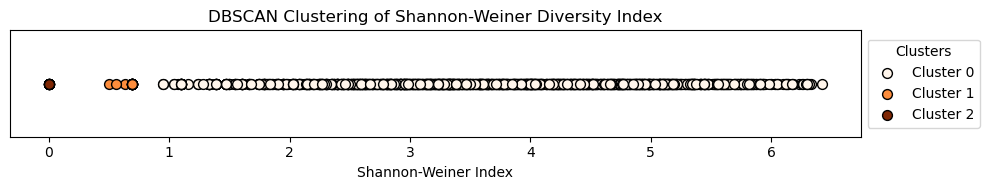

In [5]:
# Converting the dictionary to dataframe
df = pd.DataFrame(list(diversity_indexes.items()), columns=['nuts3', 'shannon_index'])

# DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=2)
df['cluster'] = dbscan.fit_predict(df[['shannon_index']])

# Unique cluster labels (including -1 for noise)
unique_clusters = sorted(df['cluster'].unique())

# Choosing a colour map for the clusters
colors = plt.cm.get_cmap('Oranges', len(unique_clusters))

# Plotting each cluster
plt.figure(figsize=(10, 2))
for i, cluster in enumerate(unique_clusters):
    cluster_data = df[df['cluster'] == cluster]
    plt.scatter(
        cluster_data['shannon_index'],
        [0]*len(cluster_data),
        label=f'Cluster {cluster}' if cluster != -1 else 'Noise',
        color=colors(i),
        edgecolor='black',
        s=50
    )

plt.yticks([])  # 1D, no need for y
plt.xlabel('Shannon-Weiner Index')
plt.title('DBSCAN Clustering of Shannon-Weiner Diversity Index')
plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5), # Outside of graph
    title='Clusters'
)
plt.tight_layout()
plt.show()